# Differential Kinetics

One important concern is dealing with systems that represent multiple lineages and processes, where
genes are likely to show different kinetic regimes across subpopulations. Distinct cell states and
lineages are typically governed by different variations in the gene regulatory networks and may
hence exhibit different splicing kinetics. This gives rise to genes that display multiple trajectories
in phase space. 

To address this, the dynamical model can be used to perform a likelihood-ratio test for differential kinetics. This way, we can detect clusters that display kinetic behavior that cannot be well explained by a single model of the overall dynamics. Clustering cell types into their different kinetic regimes then allows fitting each regime separately.

For illustration, we apply differential kinetic analysis to [dentate gyrus neurogenesis](https://scvelo.readthedocs.io/scvelo.datasets.dentategyrus.html#scvelo.datasets.dentategyrus), which comprises multiple heterogeneous subpopulations.

In [1]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.0 (python 3.7.3) on 2020-05-13 09:26.


In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

### Prepare the Data
Processing consists of gene selection, log-normalizing, and computing moments. See the previous tutorials for further explanation.

In [3]:
adata = scv.datasets.dentategyrus()

In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)


Filtered out 11019 genes that are detected in less than 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


### Basic Velocity Estimation 

In [5]:
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


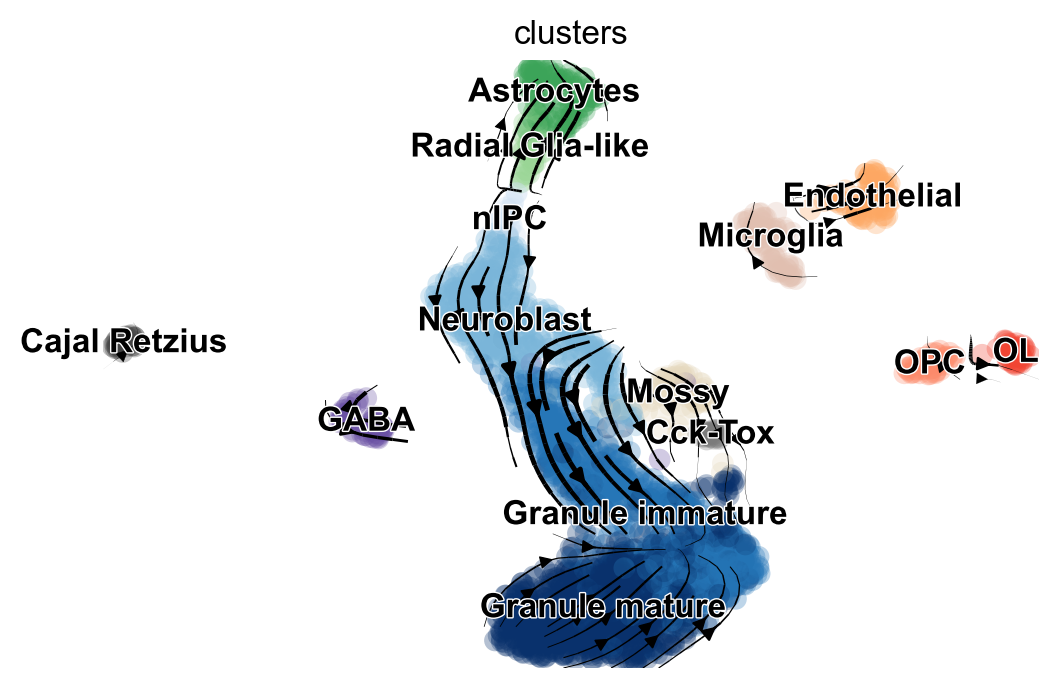

In [6]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

### Differential Kinetic Test

Distinct cell types and lineages may exhibit different kinetics regimes as these can be governed by
a different network structure. Even if cell types or lineages are related, kinetics can be differential
due to alternative splicing, alternative polyadenylation and modulations in degradation.

The dynamical model allows us to address this issue with a likelihood ratio test for differential kinetics to detect clusters/lineages that display kinetic behavior that cannot be sufficiently explained by a single model for the overall dynamics. Each cell type is tested whether an independent fit yields a significantly improved likelihood.

The likelihood ratio, following an asymptotic chi-squared distribution, can be tested for significance. Note that for efficiency reasons, by default an orthogonal regression is used instead of a full phase trajectory to test whether a cluster is well explained by the overall kinetic or exhibits a different kinetic.

In [7]:
var_names = ['Tmsb10', 'Fam155a', 'Hn1', 'Rpl6']
scv.tl.differential_kinetic_test(adata, var_names=var_names, groupby='clusters')

recovering dynamics
    finished (0:00:02) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)

outputs model fit of gene: Rpl6
testing for differential kinetics
    finished (0:00:00) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pval_kinetics', p-values of differential kinetics (adata.var)

outputs model fit of gene: Rpl6


In [8]:
scv.get_df(adata[:, var_names], ['fit_diff_kinetics', 'fit_pval_kinetics'], precision=2)

,fit_diff_kinetics,fit_pval_kinetics
index,,
Tmsb10,Endothelial,6.02e-16
Fam155a,Cajal Retzius,8.35e-161
Hn1,Microglia,3.02e-03
Rpl6,Microglia,5.69e-16


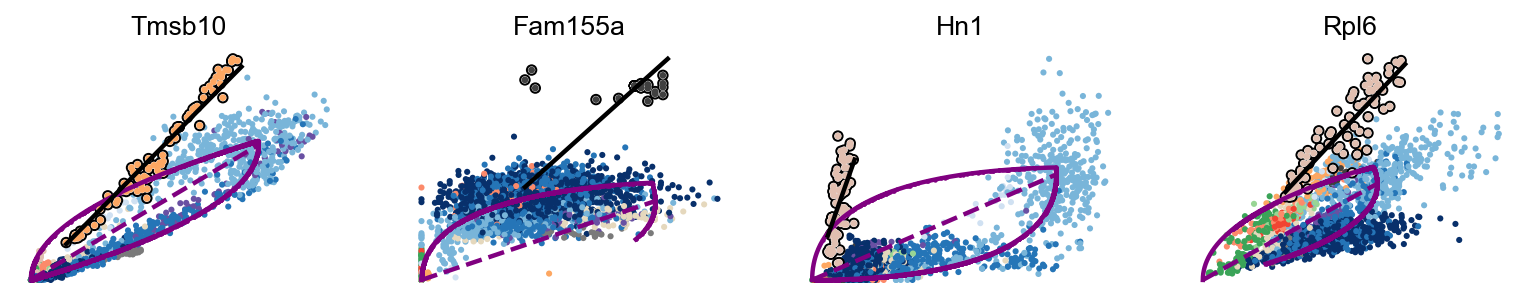

In [9]:
kwargs = dict(linewidth=2, add_linfit=True, frameon=False)
scv.pl.scatter(adata, basis=var_names, add_outline='fit_diff_kinetics', **kwargs)

In *Tmsb10*, for instance, Endothelial display a kinetic behaviour (outlined, with the black line fitted through), that cannot be well explained by the overall dynamics (purple curve).

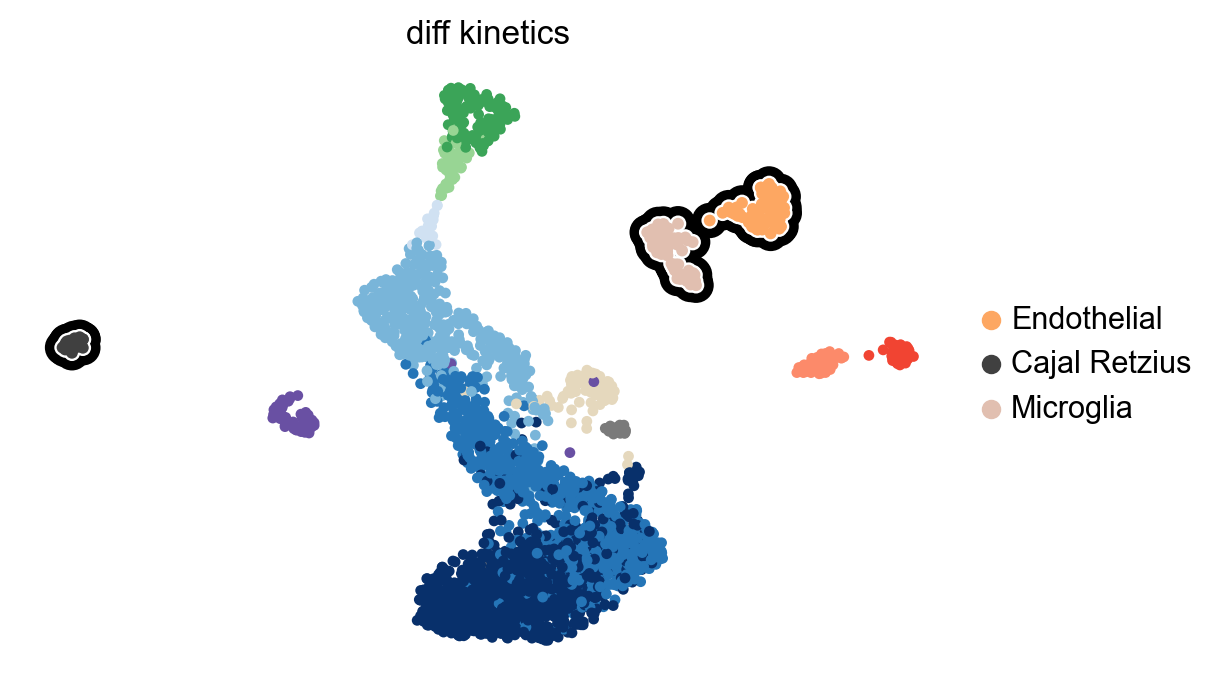

In [10]:
diff_clusters=list(adata[:, var_names].var['fit_diff_kinetics'])
scv.pl.scatter(adata, legend_loc='right', size=60, title='diff kinetics',
               add_outline=diff_clusters, outline_width=(.8, .2))

### Testing top-likelihood genes
Screening through the top-likelihood genes, we find some gene-wise dynamics that display multiple kinetic regimes. 

In [11]:
scv.tl.recover_dynamics(adata)

#adata.write('data/pancreas.h5ad', compression='gzip')
#adata = scv.read('data/pancreas.h5ad')

recovering dynamics
    finished (0:04:50) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [12]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:100]
scv.tl.differential_kinetic_test(adata, var_names=top_genes, groupby='clusters')

testing for differential kinetics
    finished (0:00:18) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pval_kinetics', p-values of differential kinetics (adata.var)


Particularly, cell types that are distinct from the main granule - such as Cck/Tox, GABA, Endothelial, and Microglia - occur frequently. 

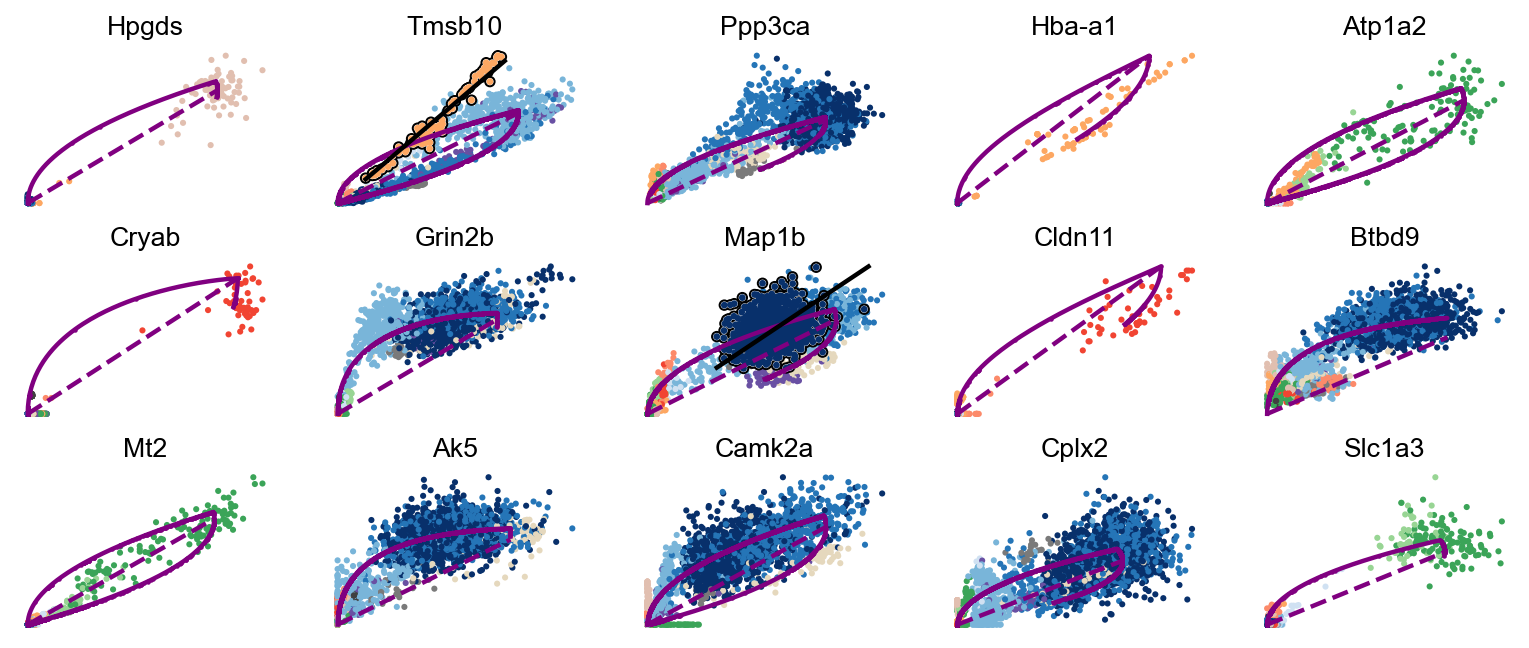

In [13]:
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, add_outline='fit_diff_kinetics', **kwargs)

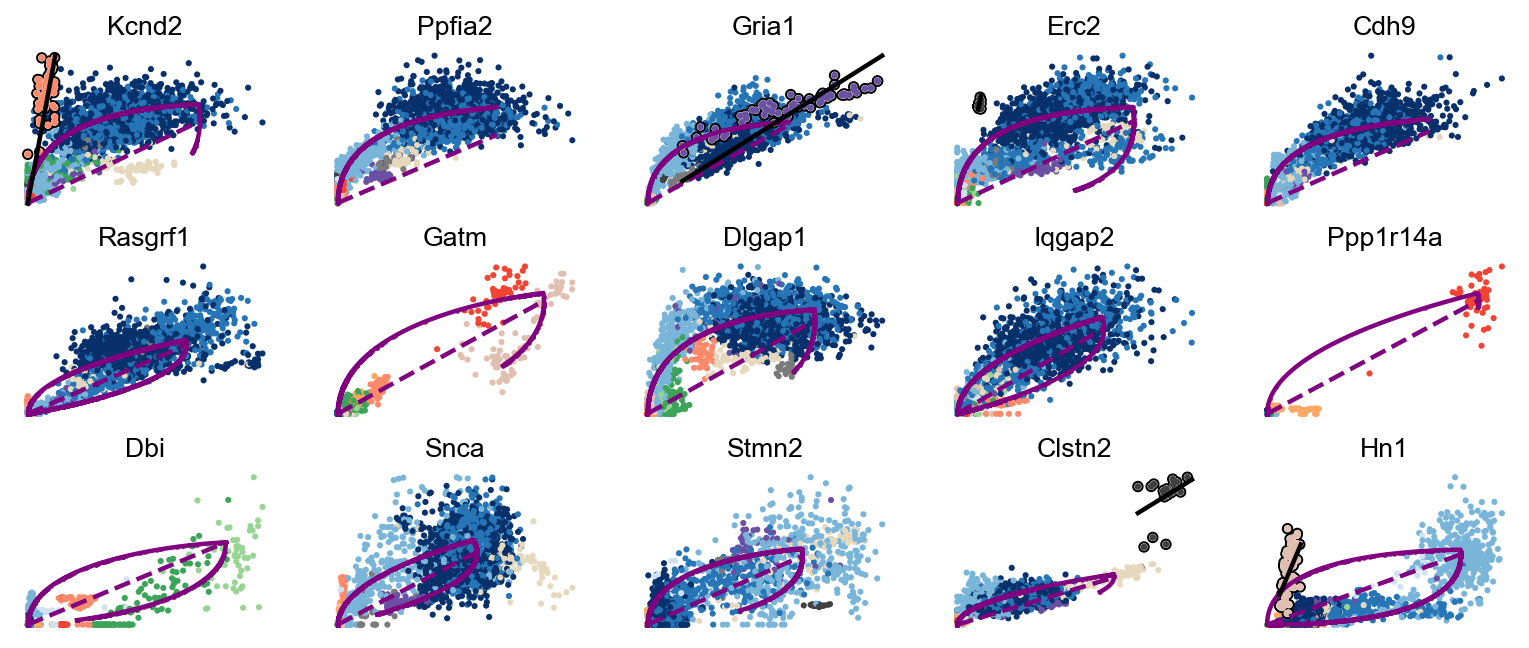

In [14]:
scv.pl.scatter(adata, basis=top_genes[15:30], ncols=5, add_outline='fit_diff_kinetics', **kwargs)

### Recompute velocities

Finally, velocities can be recomputed leveraging the information of multiple competing kinetic regimes.

In [15]:
scv.tl.velocity(adata, diff_kinetics=True)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


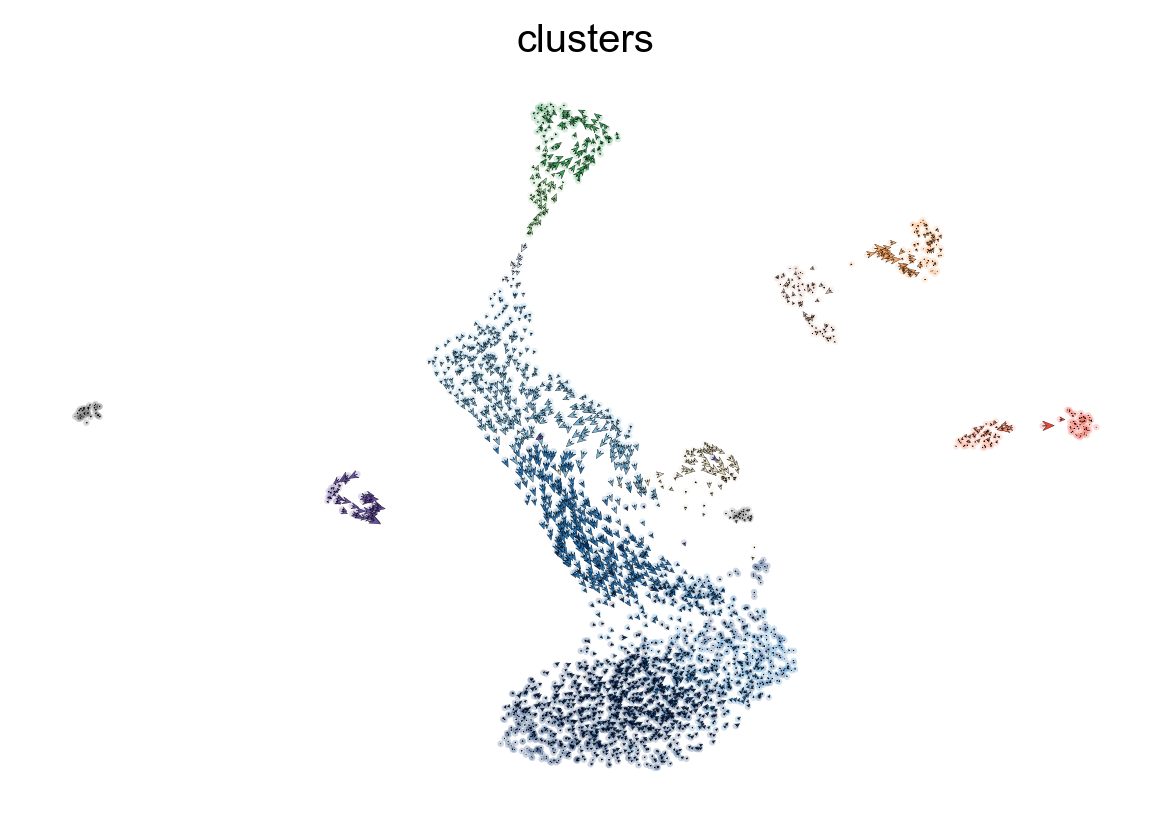

In [16]:
scv.pl.velocity_embedding(adata, dpi=120, arrow_size=2, arrow_length=2)